In [3]:
!pip install torch torchvision scikit-learn


In [4]:
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import numpy as np
from PIL import Image
import torch.nn.functional as F


In [6]:

zip_path = "/content/dataset_ready.zip"
extract_path = "/content/dataset_ready"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)


In [7]:
data_root = "/content/dataset_ready/Original Images"

image_size = 224

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], #transforms the image from PIL 0-255 HxWxC to tensor 0-1 CxHxW
        std=[0.229, 0.224, 0.225]
    )
])

dataset = datasets.ImageFolder(root=data_root, transform=transform)#pulls the class label from the sub folder and also automatically builds the data.setclasses in alphabetica order
#confirms if the label and slides are in the right folder with the right classes
print("Total classes:", len(dataset.classes))
print("Total images:", len(dataset))
print dataset.classes[:5])


Total classes: 31
Total images: 2562
Example classes: ['Akshay Kumar', 'Alexandra Daddario', 'Alia Bhatt', 'Amitabh Bachchan', 'Andy Samberg']


In [8]:
#splitting the data for 80% trainng and then %20 for testing rabndomly
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size  = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
#the model is trained using batchs and 16 for our batch size was the perfect size
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
#our train size and test size
print("Train size:", len(train_dataset))
print("Test size:", len(test_dataset))


Train size: 2049
Test size: 513


In [9]:
#tries to use gpu as the device if not then the cpu will work
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(dataset.classes)#number of people to predict

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) #CNN model resnet18 loaded and is already pretrained

# freeze all pretrained layers,which helps with reducing traning time and overfitting
for p in model.parameters():
    p.requires_grad = False

#replace final layer to match our number of people of 31
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)#moves the model to either the gpu or cpu

criterion = nn.CrossEntropyLoss() #multiclass loss
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)#our optimizer with a learning rate of 1e-3 0.001


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


In [10]:
#right inference mode which is much faster and also uses less memeory
def evaluate_model(model, loader):
    model.eval()
    preds = []
    labels = []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, p = torch.max(out, 1)
            preds.extend(p.cpu().numpy())
            labels.extend(y.cpu().numpy())
#metrics for model
    acc  = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='macro', zero_division=0)
    rec  = recall_score(labels, preds, average='macro', zero_division=0)
    return acc, prec, rec


In [11]:
#training loop using 10 epochs
epochs = 10
#stores the metrics for plotting
train_losses = []
validation_accuracies = []
validation_precisions = []
validation_recalls = []
#traning loop for each batch
#forward pass-compute loss-backprop-optimizerstep
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    #avarage loss over all the training images
    epoch_loss = running_loss / len(train_loader.dataset)


    acc, prec, rec = evaluate_model(model, test_loader)


    train_losses.append(epoch_loss)
    validation_accuracies.append(acc)
    validation_precisions.append(prec)
    validation_recalls.append(rec)
#keras style summary line of each epoch
    print(
        f"Epoch {epoch+1}/10  "
        f"Training Loss: {epoch_loss:.4f}  "
        f"Validation Accuracy: {acc:.4f}  "
        f"Validation Precision: {prec:.4f}  "
        f"Validation Recall: {rec:.4f}"
    )


Epoch 1/10 | Training Loss: 2.9820  Validation Accuracy: 0.3138  Validation Precision: 0.3827  Validation Recall: 0.2864
Epoch 2/10 | Training Loss: 2.1649  Validation Accuracy: 0.3743  Validation Precision: 0.4322  Validation Recall: 0.3619
Epoch 3/10 | Training Loss: 1.7743  Validation Accuracy: 0.4581  Validation Precision: 0.4964  Validation Recall: 0.4417
Epoch 4/10 | Training Loss: 1.5664  Validation Accuracy: 0.4425  Validation Precision: 0.5016  Validation Recall: 0.4528
Epoch 5/10 | Training Loss: 1.3851  Validation Accuracy: 0.4288  Validation Precision: 0.5289  Validation Recall: 0.4256
Epoch 6/10 | Training Loss: 1.2795  Validation Accuracy: 0.4990  Validation Precision: 0.5596  Validation Recall: 0.4959
Epoch 7/10 | Training Loss: 1.1569  Validation Accuracy: 0.5088  Validation Precision: 0.5641  Validation Recall: 0.5064
Epoch 8/10 | Training Loss: 1.0905  Validation Accuracy: 0.5029  Validation Precision: 0.5425  Validation Recall: 0.4962
Epoch 9/10 | Training Loss: 1.02

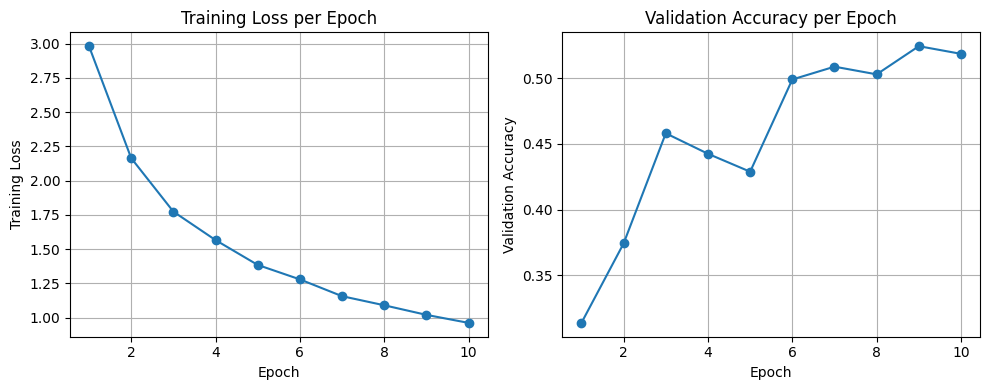

In [12]:

epochs_axis = range(1, len(train_losses)+1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs_axis, train_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_axis, validation_accuracies, marker='o')
plt.title("Validation Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()


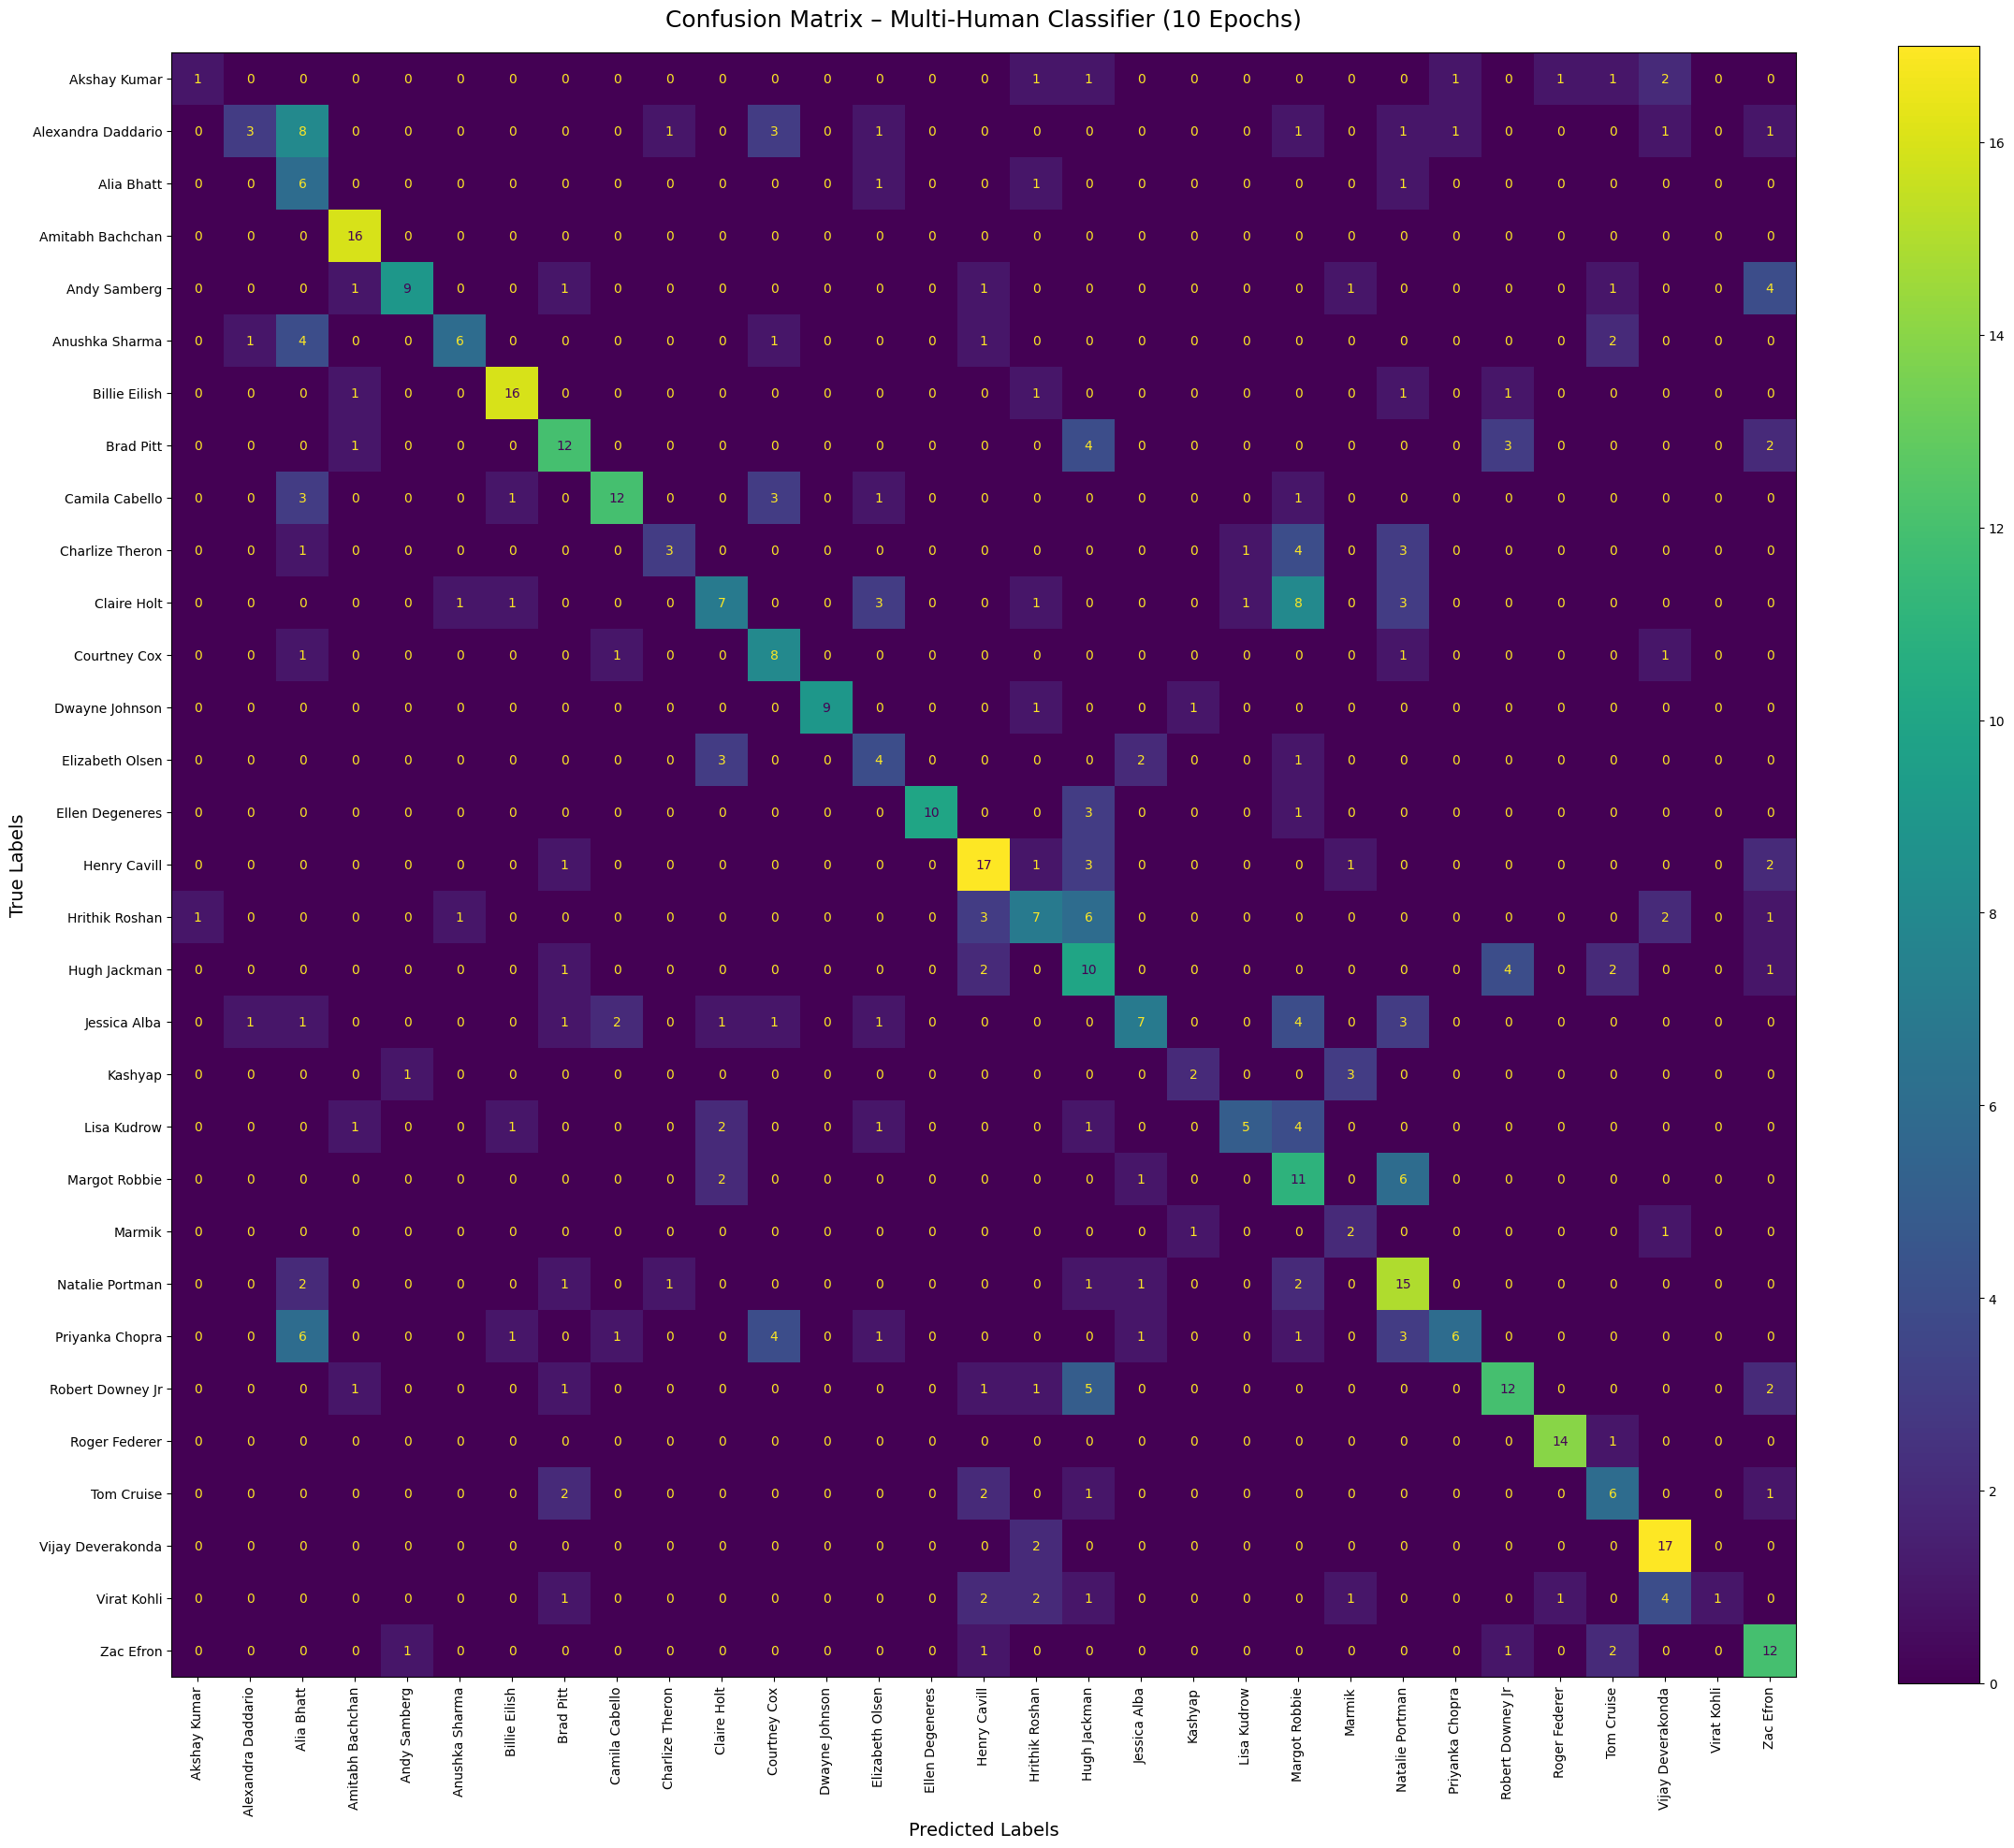

In [15]:
#confusion matrix using all predicitons vs the true labels
import numpy as np

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        _, preds_batch = torch.max(out, 1)
        all_preds.extend(preds_batch.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
#large mapping since we have 31 classes
cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(dataset.classes)))

fig, ax = plt.subplots(figsize=(22, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=dataset.classes)
disp.plot(ax=ax, cmap="viridis", colorbar=True)
#rotated x labels to help them fit into plot
plt.xticks(rotation=90, ha='center')
plt.yticks(rotation=0)
plt.subplots_adjust(bottom=0.35, top=0.95, left=0.25, right=1.05)
#used bigger fontsize and pad for clearler names on the plot
plt.title("Confusion Matrix Multi-Human Classifier ", fontsize=18, pad=20)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.tight_layout()
plt.show()


In [18]:
#Gradio UI using dataset
!pip install -q gradio

import gradio as gr
import torch
import torch.nn.functional as F
from PIL import Image


CLASS_NAMES = dataset.classes
#converts the uploaded image to tensor similar to our training model,then model logits
def infer(image: Image.Image):
    if image is None:
        return {}

    img = image.convert("RGB")
    x = transform(img).unsqueeze(0).to(device)


    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).squeeze(0).cpu().numpy() #softmax for probailities

    #k=5 to return top k label with confidence
    k = 5 if len(CLASS_NAMES) >= 5 else len(CLASS_NAMES)
    top_idx = probs.argsort()[::-1][:k]
    return {CLASS_NAMES[i]: float(probs[i]) for i in top_idx}
#UI with the image upload alongside the ranked label output
demo = gr.Interface(
    fn=infer,
    inputs=gr.Image(type="pil", label="Upload a face"),
    outputs=gr.Label(num_top_classes=5, label="Prediction (Top-5)"),
    title="Multi-Human Classifier ResNet-18",
    description="Upload a face image The app returns the most likely identity with confidence."
)

demo.launch(share=True) #allows for a temporarly public link that can be shared


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6fd0ec471c13b330b4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
